# Forecasting

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

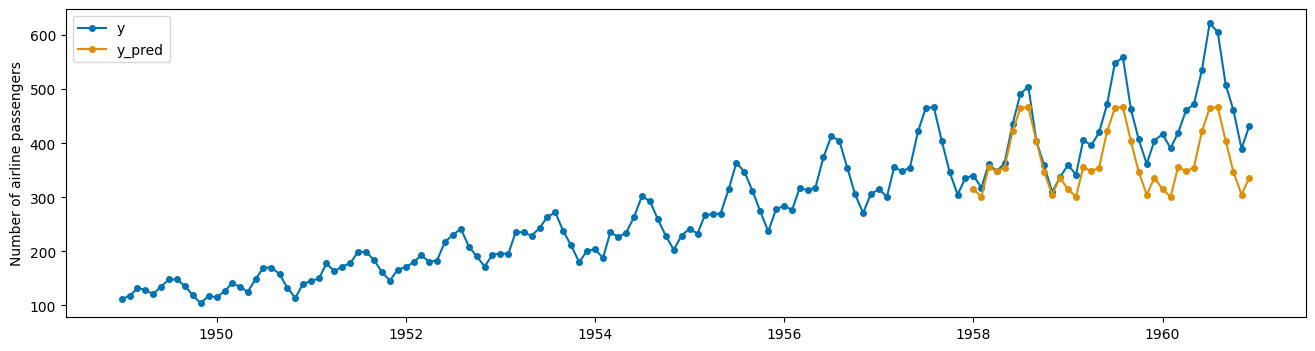

In [1]:
# Naive Forecaster with airline datset
from sktime.datasets import load_airline
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series

y = load_airline()

# specifying the forecasting algorithm
forecaster = NaiveForecaster(strategy="last", sp=12)

# fitting the forecaster
forecaster.fit(y[:-36])

# querying predictions
y_pred = forecaster.predict(fh=range(1,37))

# optional: plotting predictions and past data
plot_series(y, y_pred, labels=["y", "y_pred"])

### Observations:
* NaiveForecaster can not cope with trends. Detrending algorithm is needed.

sktime enables to build pipelines consisting of transformations and estimators (e.g. forecasters).


## Building Pipelines with sktime

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

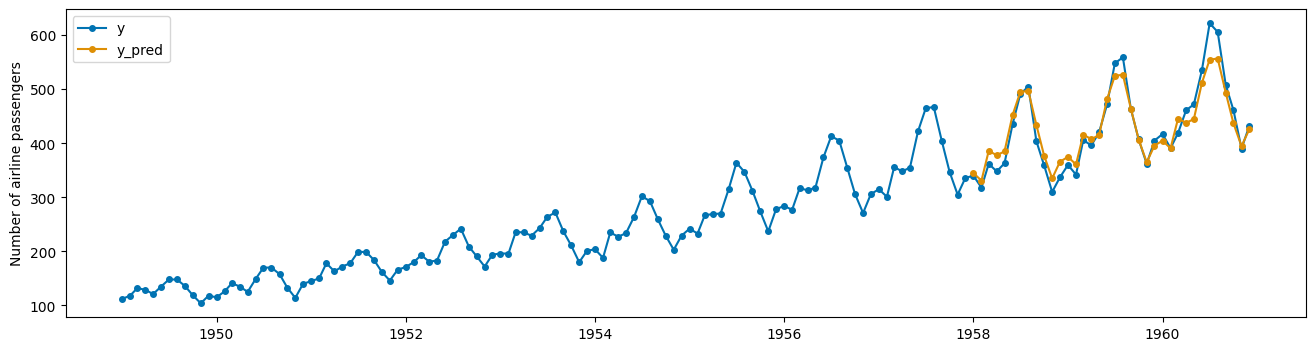

In [2]:
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender

y = load_airline()

pipe_y = TransformedTargetForecaster(
    steps=[
        ("detrend", Detrender()),
        ("deseasonalize", Deseasonalizer()),
        ("forecaster", NaiveForecaster(strategy="last", sp=12)),
    ]
)


pipe_y.fit(y=y[:-36])
y_pred = pipe_y.predict(fh=range(1,37))

plot_series(y, y_pred, labels=["y", "y_pred"])

## Probabilistic Forecasting

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

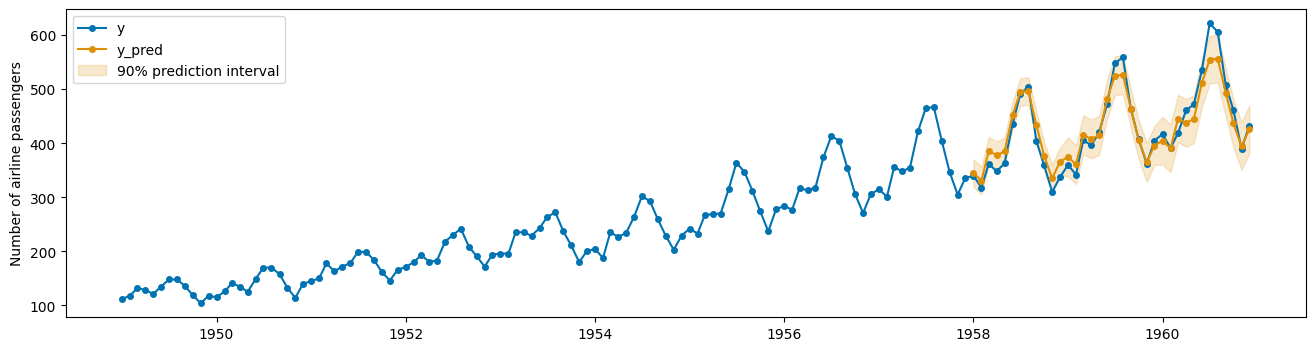

In [3]:
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender

y = load_airline()

pipe_y = TransformedTargetForecaster(
    steps=[
        ("detrend", Detrender()),
        ("deseasonalize", Deseasonalizer()),
        ("forecaster", NaiveForecaster(strategy="last", sp=12)),
    ]
)


pipe_y.fit(y=y[:-36])
y_pred = pipe_y.predict(fh=range(1,37))
y_pred_int = pipe_y.predict_interval(fh=range(1,37))

plot_series(y, y_pred, labels=["y", "y_pred"],
            pred_interval=y_pred_int,)

### Observations:
* yes there is an interval around the forecast, however, it is very small. Probably not good calibrated!
* Possible solution: Use composition pattern to create ConformalIntervals

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

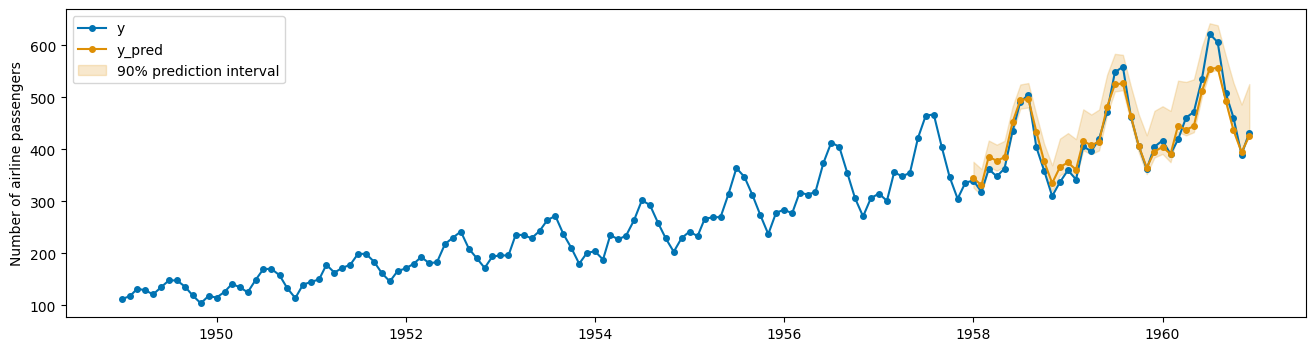

In [4]:
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.forecasting.conformal import ConformalIntervals

y = load_airline()

pipe_y = ConformalIntervals(TransformedTargetForecaster(
    steps=[
        ("detrend", Detrender()),
        ("deseasonalize", Deseasonalizer()),
        ("forecaster", NaiveForecaster(strategy="last", sp=12)),
    ]
))


pipe_y.fit(y=y[:-36])
y_pred = pipe_y.predict(fh=range(1,37))
y_pred_int = pipe_y.predict_interval(fh=range(1,37))

plot_series(y, y_pred, labels=["y", "y_pred"],
            pred_interval=y_pred_int,)

## Global Forecasting

![](./img/local_vs_global.png)

### Advantages and Disadvantages

![](./img/advantages_disadvantages.png)

### Global Forecasting Models in sktime

sktime implements and interfaces several global forecaster, we are using tags to identify capabilities of estimators like global forecasting. 

Alternatively, you can also check this via code.

In [5]:
from sktime.registry import all_estimators
# return all forecasters which handle missing data in the input by tag filtering
all_estimators("forecaster", filter_tags={"capability:global_forecasting": True}, as_dataframe=True)

,name,object
0,ChronosForecaster,<class 'sktime.forecasting.chronos.ChronosFore...
1,MOIRAIForecaster,<class 'sktime.forecasting.moirai_forecaster.M...
2,MomentFMForecaster,<class 'sktime.forecasting.hf_momentfm_forecas...
3,NeuralForecastDilatedRNN,<class 'sktime.forecasting.neuralforecast.Neur...
4,NeuralForecastGRU,<class 'sktime.forecasting.neuralforecast.Neur...
5,NeuralForecastLSTM,<class 'sktime.forecasting.neuralforecast.Neur...
6,NeuralForecastRNN,<class 'sktime.forecasting.neuralforecast.Neur...
7,NeuralForecastTCN,<class 'sktime.forecasting.neuralforecast.Neur...
8,PytorchForecastingDeepAR,<class 'sktime.forecasting.pytorchforecasting....
9,PytorchForecastingNBeats,<class 'sktime.forecasting.pytorchforecasting....


### Global forecasting from a data perspective

* Panel data, containing multiple univariate or multivariate times series.
  * multi-index
    * first n index levels determines the time series
    * last index level determines the time information

In [6]:
# Global forecasting models. E.g. use NBEATS or DeepAR.
from sktime.datasets import load_forecastingdata 

from sktime.forecasting.pytorchforecasting import PytorchForecastingNBeats

def dataset_loader():
    data = load_forecastingdata("australian_electricity_demand_dataset", return_type="pd_multiindex_hier")[0]
    data = data[data.index.get_level_values(-1) <  "2009.01.01"]
    data.index = data.index.droplevel(0)
    return data

dataset_loader()


series_value
state timestamp                        
NSW   2002-01-01 00:00:00   5714.045004
      2002-01-01 00:30:00   5360.189078
      2002-01-01 01:00:00   5014.835118
      2002-01-01 01:30:00   4602.755516
      2002-01-01 02:00:00   4285.179828
...                                 ...
TAS   2008-12-31 21:30:00    419.658862
      2008-12-31 22:00:00    401.594288
      2008-12-31 22:30:00    392.008622
      2008-12-31 23:00:00    375.544740
      2008-12-31 23:30:00    362.703306

[613680 rows x 1 columns]

<style>
table th:first-of-type {
    width: 30%;
}
table th:nth-of-type(2) {
    width: 60%;
}
</style>

| Panel Data: <br /> Representing half hourly electricity demand of  5 time series of five states in Australia: (Victoria, New South Wales, Queensland, Tasmania, South Australia) | ![](./img/explanation_panel_data.png) |
:-----------------:|:-------------------------:


Global forecaster should be able to predict all time series, even if predicted only on a subset!

In [7]:
data = dataset_loader()
set(data.index.get_level_values(0))

{'NSW', 'QUN', 'SA', 'TAS', 'VIC'}

In [8]:
y_train = data.loc[["NSW", "QUN", "SA", "TAS"]]
y_test = data.loc["VIC"]

In [9]:
y_train

series_value
state timestamp                        
NSW   2002-01-01 00:00:00   5714.045004
      2002-01-01 00:30:00   5360.189078
      2002-01-01 01:00:00   5014.835118
      2002-01-01 01:30:00   4602.755516
      2002-01-01 02:00:00   4285.179828
...                                 ...
TAS   2008-12-31 21:30:00    419.658862
      2008-12-31 22:00:00    401.594288
      2008-12-31 22:30:00    392.008622
      2008-12-31 23:00:00    375.544740
      2008-12-31 23:30:00    362.703306

[490944 rows x 1 columns]

In [10]:
y_test

,series_value
timestamp,
2002-01-01 00:00:00,3535.867064
2002-01-01 00:30:00,3383.499028
2002-01-01 01:00:00,3655.527552
2002-01-01 01:30:00,3510.446636
2002-01-01 02:00:00,3294.697156
...,...
2008-12-31 21:30:00,3705.159210
2008-12-31 22:00:00,3698.903656
2008-12-31 22:30:00,3711.339458


c:\Users\81198791\projects\tutorial_haicon_prologue_day\.venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\81198791\projects\tutorial_haicon_prologue_day\.venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\81198791\projects\tutorial_haicon_prologue_day\.venv\Li

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\81198791\projects\tutorial_haicon_prologue_day\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\81198791\projects\tutorial_haicon_prologue_day\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\81198791\projects\tutorial_haicon_prologue_day\.venv\Lib\site-packages\sktime\forecasting\base\adapters\_pytorchforecasting.py:656: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  _y.fillna(0, inplace=True)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\81198791\projects\tutorial_haicon_prologue_day\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may b

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='series_value'>)

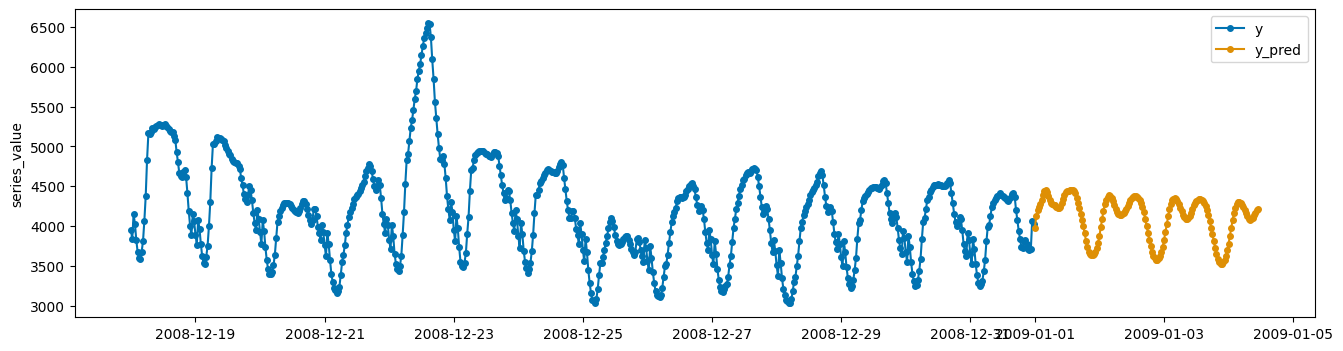

In [11]:

# define the model
model = PytorchForecastingNBeats(
     trainer_params={
         "max_epochs": 5,  # for quick test
         "limit_train_batches": 100,  # for quick test
     },
 )
# fit and predict
model.fit(y=y_train, fh=range(1, 168))

y_pred = model.predict(y=y_test, fh=range(1,168))
plot_series(y_test[-4*168:], y_pred, labels=["y", "y_pred"])


### Time Series Foundation Models

* Foundation models are pretrained global models. **You need not to train them before applying them**
* We support different architectures:
  * Chronos/ChronosBolt
  * MOIRAI
  * TimesFM
  * TinyTimesMixer
  * ...

Weights are available via HuggingFace. 


![](./img/chronos_bolt.png)


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='series_value'>)

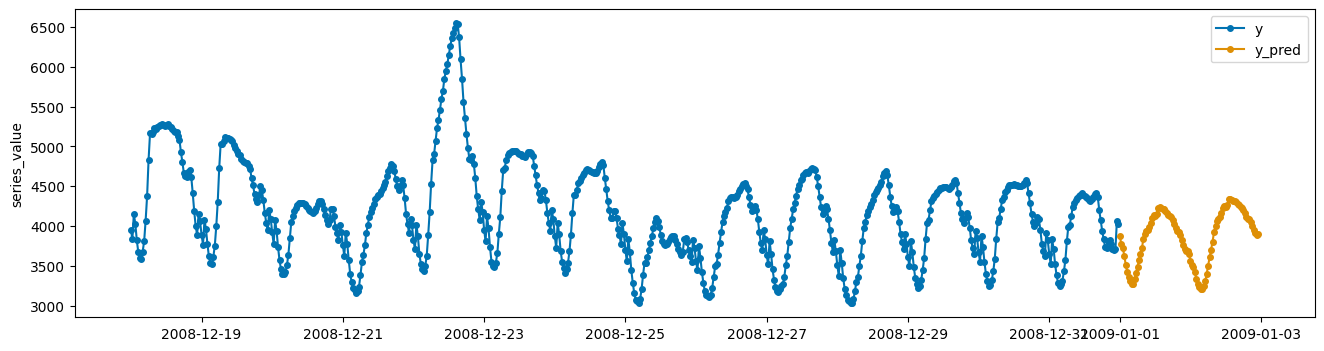

In [12]:

from sktime.forecasting.ttm import TinyTimeMixerForecaster

ttm_forecaster = TinyTimeMixerForecaster()

ttm_forecaster.fit(y_train, fh=range(1, 48*2))

ttm_pred = ttm_forecaster.predict(y=y_test)
plot_series(y_test[-4*168:], ttm_pred, labels=["y", "y_pred"])


### Composition with Global Model or Foundation Model
* It works, see example below.
* However
    * computationally very expensive, since often Compositors are using copies.
    * If trying it, limit your data
    * Your global models are in most cases not global anymore, since time series dependent fits are performed by transformations or compositions.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='series_value'>)

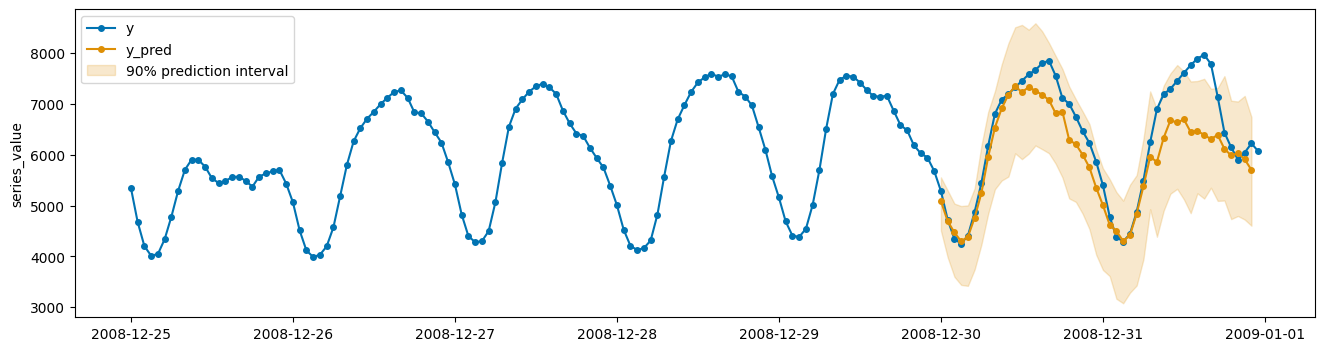

In [13]:
from sktime.forecasting.moirai_forecaster import MOIRAIForecaster

forecaster = ConformalIntervals(
    MOIRAIForecaster(
        checkpoint_path=f"Salesforce/moirai-1.1-R-small"
    ),
    sample_frac=0.2)

# MOIRAI struggles with half hourly data, so we resample to hourly.
y = y_train.loc["NSW"].resample("h").mean()

forecaster.fit(y[-512:-48], fh=range(1, 48))

pred_int = forecaster.predict_interval()
pred = forecaster.predict()
plot_series(y[-168:], pred, labels=["y", "y_pred"], pred_interval=pred_int,)

